In [1]:
import sys, os
cwd = os.getcwd()
sys.path.append(cwd)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df_ret_diario = pd.read_excel(open('Matriz Var y Cov.xlsx', 'rb'), sheet_name='BASE')
df_ret_anual = pd.read_excel(open('Matriz Var y Cov.xlsx', 'rb'), sheet_name='BASE ANUAL')

In [2]:
cols_used = ['DATE',
       'BEHGTRUU INDEX', 'BEBGTRUU INDEX',
       'S&P U.S. Treasury Bond Current 7-Year Index',
       'S&P 500 Investment Grade Corporate Bond Index', 'S&P 500',
       'VEIEX- MSCI Emerging Markets Index', 'EURO STOXX 50 ETF3'
]
ASSET_CLASSES = [c for c in cols_used if c != 'DATE']

df_ret_anual = df_ret_anual[cols_used]
df_ret_diario = df_ret_diario[cols_used]

In [3]:
df_ret_anual

,DATE,BEHGTRUU INDEX,BEBGTRUU INDEX,S&P U.S. Treasury Bond Current 7-Year Index,S&P 500 Investment Grade Corporate Bond Index,S&P 500,VEIEX- MSCI Emerging Markets Index,EURO STOXX 50 ETF3
0,2013-12-30,381.0880,981.4625,122.30,345.06,1831.369995,25.260000,40.830002
1,2014-12-31,407.5752,966.2531,130.36,370.59,2058.899902,25.320000,36.860001
2,2015-12-31,402.4758,1033.1311,133.77,369.75,2043.939941,20.809999,34.430000
3,2016-12-30,428.4961,1197.2807,135.14,388.43,2238.830078,22.680000,33.459999
4,2017-12-29,459.6775,1311.4808,138.15,411.57,2673.610107,29.080000,40.709999
5,2018-12-31,454.6293,1249.4823,140.00,403.21,2506.850098,24.190001,33.270000
6,2019-11-19,512.7212,1346.0860,150.79,454.64,3120.179932,26.920000,39.869999


### Processing

In [4]:
# df2 = df_ret_anual[ASSET_CLASSES]
# a = df2.head(n=df2.shape[0]-1).reset_index().drop('index', 1)
# b = df2.tail(n=df2.shape[0]-1).reset_index().drop('index', 1)
# df2 = (b - a) / a
# df2

# df2 = df_ret_anual[ASSET_CLASSES]
# a = df2.head(n=df2.shape[0]-1).reset_index().drop('index', 1)
# b = df2.tail(n=df2.shape[0]-1).reset_index().drop('index', 1)
# df2 = np.log(b / a)
# df2

In [5]:
usar_logaritmo = True
usar_retornos = False
usar_rendimientos = not usar_retornos

assert(usar_retornos != usar_rendimientos)

# Procesamiento
def get_returns(df):
    # Guardar fechas de cada retorno / return / o lo que sea
    dates = df.head(n=df.shape[0]-1).reset_index().drop('index', 1)['DATE']
    df = df[ASSET_CLASSES].copy()
    if usar_rendimientos:
        a = df.head(n=df.shape[0]-1).reset_index().drop('index', 1)
        b = df.tail(n=df.shape[0]-1).reset_index().drop('index', 1)
        df = b / a
        if usar_logaritmo:
            df = np.log(df)
        else:
            df = df - 1
    elif usar_retornos:
        a = df.head(n=df.shape[0]-1).reset_index().drop('index', 1)
        b = df.tail(n=df.shape[0]-1).reset_index().drop('index', 1)
        df = (b - a) / a
    else:
        raise Exception('Error')
    df['DATE'] = dates
    df = df[['DATE'] + [c for c in df.columns if c != 'DATE']]
    return df
        
ret_anual = get_returns(df_ret_anual)
ret_diario = get_returns(df_ret_diario)

In [6]:
# ret_anual
# ret_diario

In [7]:
# df_ret_anual
# df_ret_diario

In [8]:
# Interval of data-series
print(df_ret_diario.DATE.min())
print(df_ret_diario.DATE.max())

2013-12-30 00:00:00
2019-11-19 00:00:00


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Price')

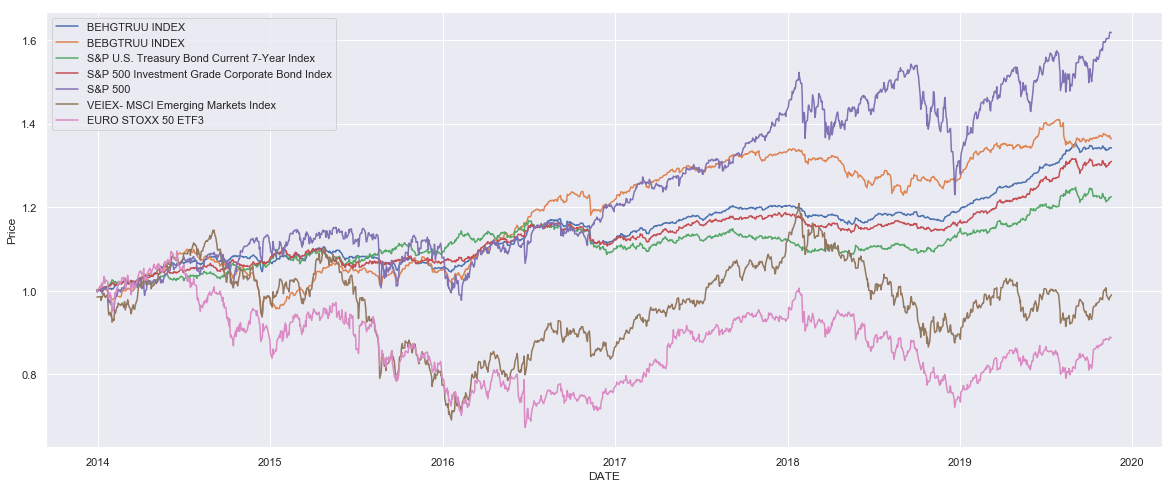

In [9]:
ret_anual['DATE'] = pd.to_datetime(ret_anual['DATE'])
ret_diario['DATE'] = pd.to_datetime(ret_diario['DATE'])

ret_acum = ret_diario.copy()
for col in ret_diario.columns.tolist():
    if col != 'DATE':
        ret_acum[col] = ret_acum[col] + 1
        ret_acum[col] = ret_acum[col].cumprod()
        
fig, ax = plt.subplots(figsize=(20, 8), ncols=1, nrows=1)
for stock in [c for c in ret_diario.columns if c != 'DATE']:
    sns.lineplot(data=ret_acum, x='DATE', y=stock, ax=ax, label=stock)
ax.set_ylabel('Price')

### Augmented Dickey-Fuller test: https://machinelearningmastery.com/time-series-data-stationary-python/

In [10]:
from statsmodels.tsa.stattools import adfuller

################
# EXPLICACION
# The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary 
# (has some time-dependent structure). 
# The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

################
# INTERPRETACION
# BEHGTRUU INDEX.1: As part of the output, we get a look-up table to help determine the ADF statistic. 
# We can see that our statistic value of -22.038992 is less than the value of -3.435 at 1%.

# This suggests that we can reject the null hypothesis with a significance level of less than 1% 
# (i.e. a low probability that the result is a statistical fluke).

for index in [c for c in ret_diario.columns if c != 'DATE']: 
    print("#########")
    print(index)
    
    result = adfuller(ret_diario[index])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

#########
BEHGTRUU INDEX
ADF Statistic: -22.085918
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
#########
BEBGTRUU INDEX
ADF Statistic: -22.895931
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
#########
S&P U.S. Treasury Bond Current 7-Year Index
ADF Statistic: -17.632135
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
#########
S&P 500 Investment Grade Corporate Bond Index
ADF Statistic: -40.511260
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
#########
S&P 500
ADF Statistic: -28.526855
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
#########
VEIEX- MSCI Emerging Markets Index
ADF Statistic: -33.752167
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
#########
EURO STOXX 50 ETF3
ADF Statistic: -20.709987
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


### Definir funcion para optimizar y para determinar estacionariedad

In [45]:
import numpy as np
from scipy import optimize

def get_optimum_weights(μ, σ, Σ, w_bound, max_equity):
    
    # Inicializacion de weights
    w = np.ones(Σ.shape[0])
    
    # Maximizar r_expected para un σ dado
    r_expected = lambda w: -1 * w.dot(μ)

    # Constraint sobre los weights: deben sumar 1
    w_constraint = ({'type': 'eq', 'fun': lambda w: sum(w) - 1.})
    
    # Contraint equity suma < 30% (importante el orden en que estan los weights respecto a μ !!!). Asume >= 0
    w_constraint_level2_equity = ({'type': 'ineq', 'fun': lambda w: max_equity - w[4] - w[5] - w[6]})

    # Optimization
    w_opt = optimize.minimize(r_expected, w, method = 'SLSQP', 
                              constraints = [w_constraint, w_constraint_level2_equity], 
                              bounds = w_bound)
    return w_opt

### Usamos retornos anualizados para matrix de varianzas-covarianzas

In [47]:
# ret_anual.columns
# BEHGTRUU INDEX => Bloomberg USD High Yield Emerging Markets Bond Index
# BEBGTRUU => Bloomber USD Investment Grade Emergin Market

In [43]:
# print(ret_anual[ASSET_CLASSES].cov().values.diagonal())
# print(ret_diario[ASSET_CLASSES].cov().values.diagonal())
# ret_anual[ASSET_CLASSES].cov().values

In [46]:
# ASSET CLASSES = [
#     'BEHGTRUU INDEX', 'BEBGTRUU INDEX',
#     'S&P U.S. Treasury Bond Current 7-Year Index',
#     'S&P 500 Investment Grade Corporate Bond Index', 'S&P 500',
#     'VEIEX- MSCI Emerging Markets Index', 'EURO STOXX 50 ETF3'
# ]

# w_bound = [(0, 0.10), (0, 0.15), (0.05, 0.20), (0.05, 0.45), (0, 0.1), (0, 0.1), (0, 0.1)]
# max_equity = 0.25

w_bound = [(0, 0.10), (0, 0.15), (0.05, 0.20), (0.05, 0.45), (0.1, 0.25), (0, 0.1), (0, 0.1)]
max_equity = 0.30

Σ = ret_diario[ASSET_CLASSES].cov().values

# Rendimientos esperados
μ = [0.0966, 0.0498, 0.0336, 0.0472, 0.0824, 0.05, 0.05]

# Volatilidad aceptable
σ = 0.0535

# Optimizacion
optimum = get_optimum_weights(μ, σ, Σ, w_bound, max_equity)
print ('Success: ', optimum.success)
print ('Weights: ', [np.round(a, 5) for a in optimum.x])
print ('Expected return: ' , np.round(optimum.x.dot(μ), 4))
print ('Total sum of weights: ', round(sum(optimum.x), 2))

Success:  True
Weights:  [0.1, 0.15, 0.05, 0.4, 0.25, 0.025, 0.025]
Expected return:  0.0608
Total sum of weights:  1.0


In [38]:
# Observacion:
# TODOS LOS WEIGHTS SE SETEAN EN EL MAXIMO POSIBLE, A EXCEPCION DEL 7-YEAR TREASURY, QUE LO TIRA MAS HACIA ABAJO DE SU LIMITE SUPERIOR

In [54]:
# ret_diario[ASSET_CLASSES].cov().values.diagonal()
# ret_anual[ASSET_CLASSES].cov().values.diagonal()

In [55]:
# ret_diario[ASSET_CLASSES].cov().to_csv('matriz varianzas covarianzas rendimientos diarios (Pedro).csv')